In [30]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=2
import numpy as np
import os
from vis_utils.loaders import load_dataset
from vis_utils.plot import  plot_scatter
import sys
sys.path.append("..")
from scripts.utils import get_noise_in_estimator, get_path
import pickle
import cne
import matplotlib.pyplot as plt
import matplotlib

from openTSNE.affinity import Affinities
from vis_utils.tsne_wrapper import TSNEwrapper
from vis_utils.utils import  save_dict, load_dict


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: CUDA_VISIBLE_DEVICES=2


In [31]:
fig_path = get_path("figures")

In [32]:
dataset = "mnist"

# parameters
a = 1.0
b = 1.0
log_embds = False
log_norms = False
log_kl = False
optimizer = "sgd"
n_epochs = 750
loss_mode = "neg_sample"
n_noise = 5
rescale = 1.0  # how to rescale the initialization
anneal_lr = True
momentum = 0.0
lr_min_factor = 0.0
clamp_low = 1e-10
on_gpu = True
noise_in_estimator = 1.  # reparametrization of Z_bar, default of 1. corresponds to normal negative sampling
init_str = "pca"

root_path = get_path("data")

In [33]:
# get data
k = 15
x, y, sknn_graph, pca2 = load_dataset(root_path, dataset, k=k)

print(sknn_graph.nnz)

1500006


# Baselines

## tsne

In [35]:
dataset = "mnist"
k = 15
seed = 0
seeds = [0, 1, 2]
perplexity = 2 * k  # has no effect as sknn_graph is used
rescale_tsne = True
log_kl = False
log_embds = False
log_Z = False
log_time = True

In [36]:

if rescale_tsne:
    pca_tsne = pca2 / np.std(pca2[:, 0]) / 10000
else:
    pca_tsne = pca2
affinities_tSNE = Affinities()
affinities_tSNE.P = (sknn_graph / sknn_graph.sum()).tocsr()
# t-SNE
n_early_epochs = 250
n_epochs_tsne = 500
tsne_data_list = []
for s in seeds:
    file_name = os.path.join(root_path,
                             "mnist",
                             f"tsne_bin_k_{k}_n_epochs_{n_epochs_tsne}_n_early_epochs_{n_early_epochs}_perplexity_{perplexity}_seed_{s}_log_kl_{log_kl}_log_embds_{log_embds}_log_time_{log_time}_init_pca_rescale_{rescale_tsne}.pkl")
    print(file_name)
    try:
        tsne_data = load_dict(file_name)
    except FileNotFoundError:
        tsne = TSNEwrapper(perplexity=perplexity,
                           metric="euclidean",
                           n_jobs=-1,  # n_jobs=-10 does not work well, the cell does not print anything
                           random_state=s,
                           verbose=True,
                           n_iter=n_epochs,
                           early_exaggeration_iter=n_early_epochs,
                           callbacks_every_iters=1,
                           log_kl=log_kl,
                           log_embds=log_embds,
                           log_Z=log_Z,
                           log_time=log_time,
                           initialization=pca_tsne)
        embd = tsne.fit_transform(x, affinities=affinities_tSNE)
        save_dict(tsne.aux_data, file_name)
        tsne_data = tsne.aux_data
    tsne_data_list.append(tsne_data)



/export/ial-nfs/user/sdamrich/nce_data/mnist/tsne_bin_k_15_n_epochs_500_n_early_epochs_250_perplexity_30_seed_0_log_kl_False_log_embds_False_log_time_True_init_pca_rescale_True.pkl
/export/ial-nfs/user/sdamrich/nce_data/mnist/tsne_bin_k_15_n_epochs_500_n_early_epochs_250_perplexity_30_seed_1_log_kl_False_log_embds_False_log_time_True_init_pca_rescale_True.pkl
/export/ial-nfs/user/sdamrich/nce_data/mnist/tsne_bin_k_15_n_epochs_500_n_early_epochs_250_perplexity_30_seed_2_log_kl_False_log_embds_False_log_time_True_init_pca_rescale_True.pkl


In [37]:
times_tsne = np.array([tsne_data["time"] for tsne_data in tsne_data_list])
print(times_tsne.mean())
print(times_tsne.std())

81.90624364217122
3.6820459923034106


In [38]:
times_tsne

array([80.44111705, 78.31142354, 86.96619034])

## UMAP

In [39]:
# numbers copied from environment with original UMAP installation

times_umap = np.array([2*60+33, 2*60+39, 2*60+31])
times_umap

array([153, 159, 151])

# Varying batch size

In [40]:
batch_sizes = [2**power for power in range(7,21)]
batch_sizes.append(1500006)
batch_sizes = np.array(batch_sizes)[::-1]

batch_sizes_str = [rf"$2^{{{power}}}$" for power in np.around(np.log2(batch_sizes)).astype(int)]

seeds = [0, 1, 2]


In [41]:
embedders_nonparam_gpu = []
for batch_size in batch_sizes:
    embedders_by_seed = []
    for s in seeds:
        file_name = os.path.join(root_path,
                                     dataset,
                                     f"cne_{loss_mode}_n_noise_{n_noise}_noise_in_estimator_{noise_in_estimator}_n_epochs_{n_epochs}_init_{init_str}_rescale_{rescale}_bs_{batch_size}"
                                     f"_optim_{optimizer}_anneal_lr_{anneal_lr}_lr_min_factor_{lr_min_factor}_momentum_{momentum}_param_False_clamp_low_{clamp_low}_seed_{s}.pkl"
                                     )

        with open(file_name, "rb") as file:
            embedder = pickle.load(file)

        embedders_by_seed.append(embedder)
    embedders_nonparam_gpu.append(embedders_by_seed)

In [42]:
batch_sizes_param_gpu = [2**power for power in range(7,21)]
# batch_sizes_param_gpu.append(1500006)  # too large, does not fit on gpu
batch_sizes_param_gpu = np.array(batch_sizes_param_gpu)[::-1]

embedders_param_gpu = []
for batch_size in batch_sizes_param_gpu: #batch_sizes:
    embedders_by_seed = []
    for s in seeds:
        file_name = os.path.join(root_path,
                                     dataset,
                                     f"cne_{loss_mode}_n_noise_{n_noise}_noise_in_estimator_{noise_in_estimator}_n_epochs_{n_epochs}_init_{init_str}_rescale_{rescale}_bs_{batch_size}"
                                     f"_optim_{optimizer}_anneal_lr_{anneal_lr}_lr_min_factor_{lr_min_factor}_momentum_{momentum}_param_True_clamp_low_{clamp_low}_seed_{s}.pkl"
                                     )

        with open(file_name, "rb") as file:
            embedder = pickle.load(file)

        embedders_by_seed.append(embedder)
    embedders_param_gpu.append(embedders_by_seed)

In [43]:
embedders_param_cpu = []
for batch_size in batch_sizes:
    embedders_by_seed = []
    for s in seeds:
        file_name = os.path.join(root_path,
                                     dataset,
                                     f"cne_{loss_mode}_n_noise_{n_noise}_noise_in_estimator_{noise_in_estimator}_n_epochs_{n_epochs}_init_{init_str}_rescale_{rescale}_bs_{batch_size}"
                                     f"_optim_{optimizer}_anneal_lr_{anneal_lr}_lr_min_factor_{lr_min_factor}_momentum_{momentum}_param_True_clamp_low_{clamp_low}_seed_{s}_device_cpu.pkl"
                                     )

        with open(file_name, "rb") as file:
            embedder = pickle.load(file)

        embedders_by_seed.append(embedder)
    embedders_param_cpu.append(embedders_by_seed)

In [44]:
embedders_nonparam_cpu = []
for batch_size in batch_sizes:
    embedders_by_seed = []
    for s in seeds:
        file_name = os.path.join(root_path,
                                     dataset,
                                     f"cne_{loss_mode}_n_noise_{n_noise}_noise_in_estimator_{noise_in_estimator}_n_epochs_{n_epochs}_init_{init_str}_rescale_{rescale}_bs_{batch_size}"
                                     f"_optim_{optimizer}_anneal_lr_{anneal_lr}_lr_min_factor_{lr_min_factor}_momentum_{momentum}_param_False_clamp_low_{clamp_low}_seed_{s}_device_cpu.pkl"
                                     )

        with open(file_name, "rb") as file:
            embedder = pickle.load(file)

        embedders_by_seed.append(embedder)
    embedders_nonparam_cpu.append(embedders_by_seed)

In [45]:
times_nonparam_gpu = np.array([[embedder.time for embedder in l] for l in embedders_nonparam_gpu])
times_param_gpu = np.array([[embedder.time for embedder in l] for l in embedders_param_gpu])
times_nonparam_cpu = np.array([[embedder.time for embedder in l] for l in embedders_nonparam_cpu])
times_param_cpu = np.array([[embedder.time for embedder in l] for l in embedders_param_cpu])


In [46]:
cmap = plt.get_cmap("tab10")

In [47]:
plt.style.use("default")

matplotlib.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams["font.family"] = "serif"
plt.rcParams['font.serif'] = "Times New Roman"
cmap = matplotlib.cm.get_cmap("tab10")

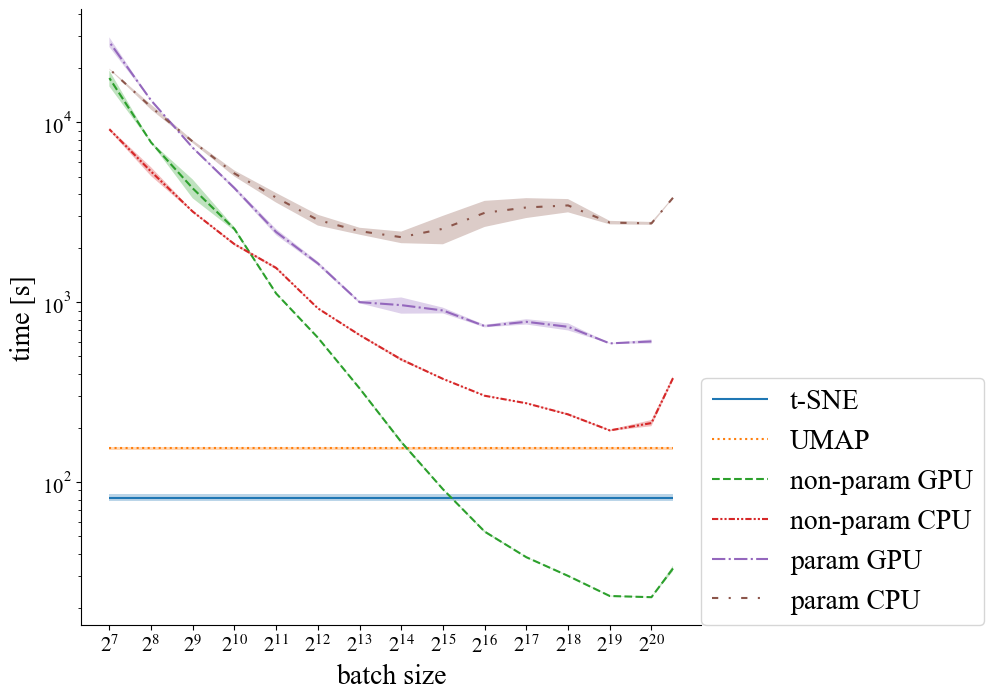

In [54]:
plt.figure(figsize=(8,8))


# baselines
plt.hlines(y=times_tsne.mean(), xmin=batch_sizes.min(), xmax=batch_sizes.max(), color=cmap(0), label="t-SNE", linestyles="solid")
plt.fill_between(batch_sizes,
                 times_tsne.mean() + times_tsne.std(),
                 times_tsne.mean() - times_tsne.std(),
                 alpha=0.3)

plt.hlines(y=times_umap.mean(), xmin=batch_sizes.min(), xmax=batch_sizes.max(), color=cmap(1), label="UMAP", linestyles="dotted")
plt.fill_between(batch_sizes,
                 times_umap.mean() + times_umap.std(),
                 times_umap.mean() - times_umap.std(),
                 alpha=0.3)


# varying batch sizes
# non-param GPU
plt.plot(batch_sizes, times_nonparam_gpu.mean(1), color=cmap(2), label= "non-param GPU", linestyle="dashed", )
plt.fill_between(batch_sizes,
                 times_nonparam_gpu.mean(1) - times_nonparam_gpu.std(1),
                 times_nonparam_gpu.mean(1) + times_nonparam_gpu.std(1),
                 alpha=0.3)

# non-param CPU
plt.plot(batch_sizes, times_nonparam_cpu.mean(1), color=cmap(3), label= "non-param CPU", linestyle=(0, (3, 1, 1, 1, 1, 1)))
plt.fill_between(batch_sizes,
                 times_nonparam_cpu.mean(1) - times_nonparam_cpu.std(1),
                 times_nonparam_cpu.mean(1) + times_nonparam_cpu.std(1),
                 alpha=0.3)

# param GPU
plt.plot(batch_sizes_param_gpu, times_param_gpu.mean(1), color=cmap(4), label= "param GPU", linestyle="dashdot")

plt.fill_between(batch_sizes_param_gpu,
                 times_param_gpu.mean(1) - times_param_gpu.std(1),
                 times_param_gpu.mean(1) + times_param_gpu.std(1),
                 alpha=0.3)

# param CPU
plt.plot(batch_sizes, times_param_cpu.mean(1), color=cmap(5), label= "param CPU", linestyle=(0, (3, 5, 1, 5)))
plt.fill_between(batch_sizes,
                 times_param_cpu.mean(1) - times_param_cpu.std(1),
                 times_param_cpu.mean(1) + times_param_cpu.std(1),
                 alpha=0.3)


plt.yscale("log")
plt.xscale("log")
plt.xticks(batch_sizes[1:], batch_sizes_str[1:], fontsize=15)
plt.yticks(fontsize=(15))
plt.xlabel("batch size", fontsize=20)
plt.ylabel("time [s]", fontsize=20)
plt.gca().xaxis.set_minor_locator(plt.NullLocator())

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)


handles, labels = plt.gca().get_legend_handles_labels()
order = [4,5,0,1,2,3]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=20, loc=(1,0))

plt.savefig(os.path.join(fig_path,
                         "runtime_bs.png"),
                bbox_inches='tight',
                pad_inches=0,
                dpi=200)


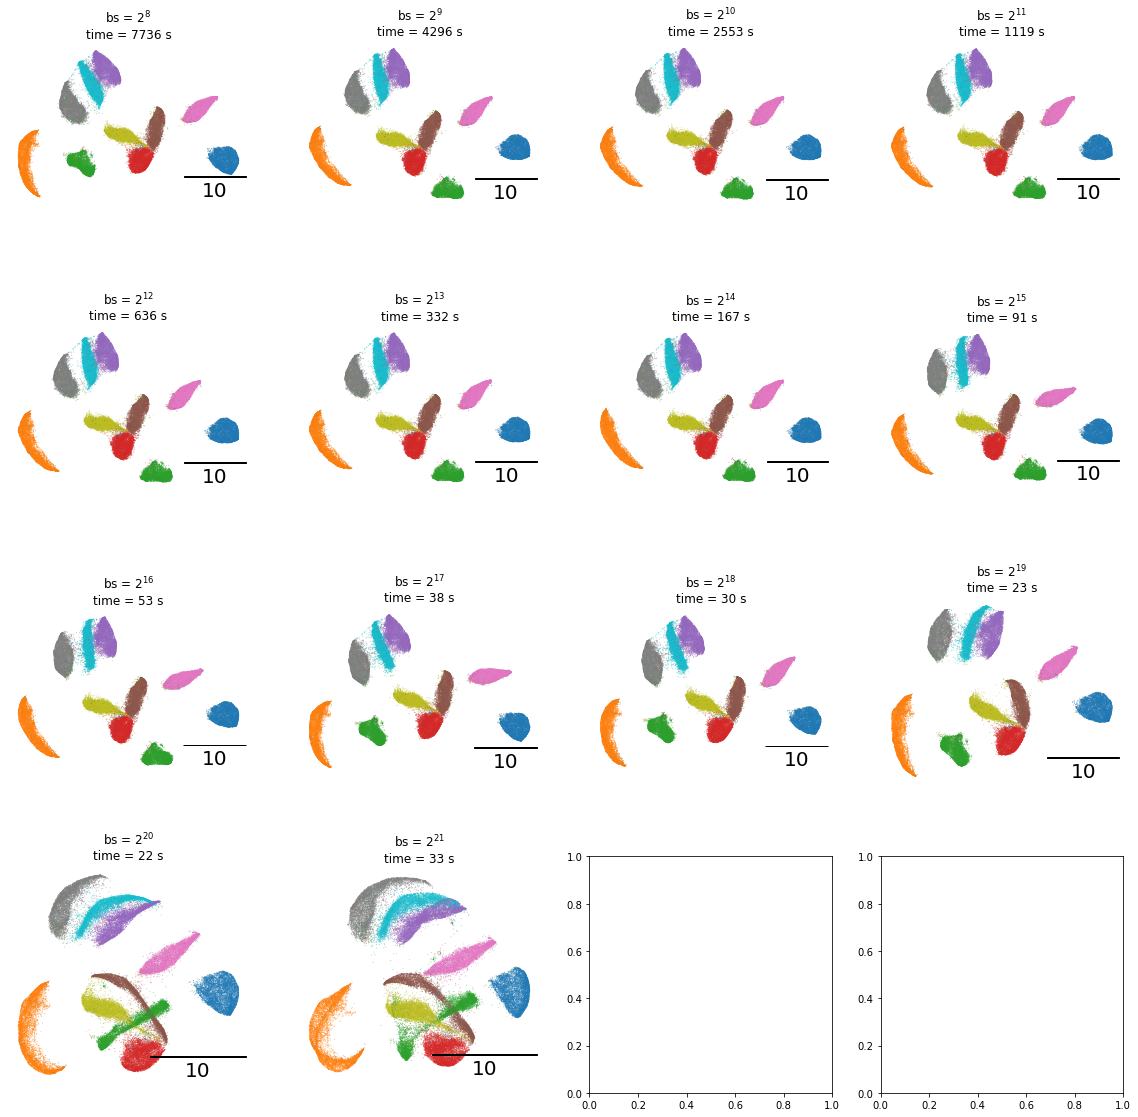

In [20]:
n_rows = 4
n_cols = 4
fig, ax = plt.subplots(n_rows,n_cols, figsize=(20,20))
n_exp = len(embedders_nonparam_gpu)
for i in range(n_exp):
    embd = embedders_nonparam_gpu[::-1][i][0].callback.embds[-1]
    cax = ax[int(i / n_cols), i % n_cols]
    plot_scatter(cax,
                 embd,
                 y,
                 f"bs = {batch_sizes_str[::-1][i]}" + "\n"+ f"time = {times_nonparam_gpu.mean(1)[::-1][i].astype(int)} s" )
    plt.savefig(os.path.join(fig_path,
                             "embd_bs.png"),
                bbox_inches='tight',
                pad_inches=0,
                dpi=200)